In [19]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# mnist_data = list(mnist_data)[:4096]

In [20]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import glob

In [21]:
import zipfile
import os

!wget --no-check-certificate \
    "http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar" \
    -O "/tmp/imgs.rar"

--2021-11-13 05:47:27--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘/tmp/imgs.rar’

/tmp/imgs.rar       100%[===================>] 132.54M   103MB/s    in 1.3s    

2021-11-13 05:47:28 (103 MB/s) - ‘/tmp/imgs.rar’ saved [138983573/138983573]



In [22]:
!pip install patool
import patoolib
!mkdir /tmp/dataset
patoolib.extract_archive("/tmp/imgs.rar", outdir="/tmp/dataset/")

mkdir: cannot create directory ‘/tmp/dataset’: File exists
patool: Extracting /tmp/imgs.rar ...
patool: running /usr/bin/unrar x -- /tmp/imgs.rar
patool:     with cwd='/tmp/dataset/'
patool: ... /tmp/imgs.rar extracted to `/tmp/dataset/'.


'/tmp/dataset/'

In [23]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/train/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/train/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/train/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/other"

In [24]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/test/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/test/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/test/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/other"

In [25]:
imdir = "/tmp/dataset/Linnaeus 5 128X128/train/"
tmdir = "/tmp/dataset/Linnaeus 5 128X128/test/"
train_files = []
test_files = []
[train_files.extend(glob.glob(imdir + '*'))]
x = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in train_files]
x_train = np.asarray(x, dtype=np.float32)
[test_files.extend(glob.glob(tmdir + '*'))]
x1 = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in test_files]
x_test = np.asarray(x1, dtype=np.float32)

In [26]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [27]:
x_test = x_test[:, None, :,:]
x_train = x_train[:, None, :, :]


In [28]:
# x_train = x_train[..., tf.newaxis]

# x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(6000, 1, 128, 128)
(2000, 1, 128, 128)


In [29]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 25
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        # gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [30]:
noise_factor = 0.1
x1 = x_train + np.array(noise_factor * torch.normal(0, 1, size=x_train.shape))
xt1 = x_test + np.array(noise_factor * torch.normal(0, 1, size=x_test.shape))


# x2 = add_gaussian_noise(x_train)
# xt2 = add_gaussian_noise(x_test)

# x2 = x2[..., tf.newaxis]
# xt2 = xt2[..., tf.newaxis]
# x_train_noisy=x1+x2
# x_test_noisy=xt1+xt2
x_train_noisy=x1
x_test_noisy=xt1

In [31]:
from torchvision.models import resnet50
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # self.encoder = nn.Sequential( # like the Composition layer you built
        #     nn.Conv2d(1, 16, 3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(16, 32, 3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, 7)
        # )

        res50_model = resnet50(pretrained=True)
        self.res50_conv = nn.Sequential(*list(res50_model.children())[:6])
        self.res50_conv[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.res50_conv(x)
        x = self.decoder(x)
        return x

In [41]:
batch_size=32
torch.manual_seed(42)
# train_loader = torch.utils.data.DataLoader(x_train_noisy, 
#                                                batch_size=batch_size, 
#                                                shuffle=True)
test_loader = torch.utils.data.DataLoader(x_test_noisy, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [42]:
import copy 
model = Autoencoder()
best_loss=100


In [43]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    best_loss=100
    outputs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        for img in train_loader:
            # img = data
            # print(img.shape)
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)

        if loss<best_loss:
          best_loss = loss
          best_model_wts = copy.deepcopy(model.state_dict()) 
    return outputs,best_model_wts

In [44]:
checkpoint = torch.load('auto.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
epochs = checkpoint['epoch']


Previously trained model weights state_dict loaded...


In [56]:
output=[]

batch_size=32
criterion = nn.MSELoss() # mean square error loss

# test_loader = torch.utils.data.DataLoader(x_test_noisy, 
#                                             batch_size=batch_size, 
#                                             shuffle=False)
outputs = []
model.eval()
count = 0
for img in x_test_noisy:
    count += 1
    if count == 11:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]))
    # loss = criterion(recon, img)
    # print(type(recon))
    print(recon.shape)
    output.append(recon)

    


torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


In [59]:
print((output[i]).detach().numpy().squeeze().shape)

(128, 128)


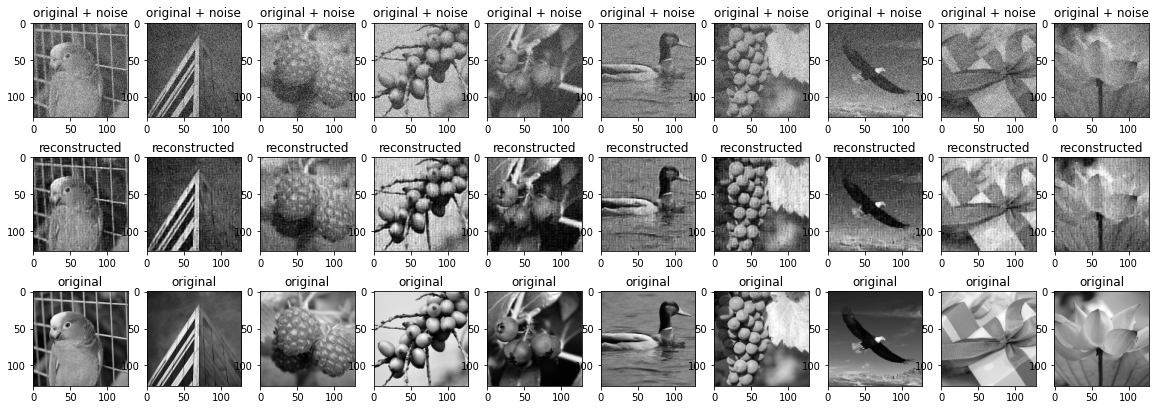

In [60]:
import matplotlib.pyplot as plt
import tensorflow as tf
n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 

  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow((output[i]).detach().numpy().squeeze()) 

  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 


plt.show()

Training


In [ ]:

max_epochs = 5
outputs,best_model_wts = train(model, num_epochs=max_epochs)
# model.state_dict()

In [ ]:
model.load_state_dict(best_model_wts)


In [ ]:
torch.save({
            'epoch': max_epochs,
            'model_state_dict': model.state_dict(),
            }, 'auto.pth')